In [1]:
import pandas as pd
import numpy as np
from math import ceil
from pandas import DataFrame
from datetime import datetime
from sklearn.cluster import KMeans
from pandas import Series
from sklearn.externals import joblib

D:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [177]:
data = pd.read_excel('RFM聚类分析数据源.xlsx',encoding = 'UTF-8') # 读取原始数据，指定UTF-8编码

data.head()

,用户编码,首次投资时间,最近一次投资时间,总计投资总金额,总计投标总次数
0,45B3CCE7-957B-4D54-9626-6D62731D119B,2016-06-25,2016-06-26,20000.0,3
1,9921C535-75FC-4695-8551-32B8D717B4A5,2016-06-26,2016-06-26,50000.0,3
2,2F00D4E3-CC7D-4DB1-B210-6F095156C5B8,2016-06-13,2016-06-19,108000.0,4
3,150218D8-BF32-406D-A3A8-8A19CB1E85AA,2016-06-16,2016-06-16,30000.0,3
4,98C26D4A-708F-4334-B3D7-EDAE9FD240C8,2016-06-27,2016-06-27,100000.0,3


In [178]:
deadline_time = datetime(2016,7,20)
print(deadline_time)
# 时间相减 得到天数 timedelta64类型
diff_R = deadline_time - data["最近一次投资时间"]
R = []
for i in diff_R:
    days = i.days
    R.append(days)

2016-07-20 00:00:00


In [179]:
'''
用户在投时长(月
Python没有直接获取月数差的函数
1、获取用户在投天数
2、月=在投天数/30，向上取整
'''
diff = deadline_time - data["首次投资时间"]
diff.head()

0   25 days
1   24 days
2   37 days
3   34 days
4   23 days
Name: 首次投资时间, dtype: timedelta64[ns]

In [180]:
# 利用向上取整函数
months = []
for i in diff:
    month = ceil(i.days/30)
    months.append(month)

months[0:5]

[1, 1, 2, 2, 1]

In [181]:
# 月均投资次数
month_ave = data["总计投标总次数"]/months
F = month_ave.values
F[0:5]

array([3. , 3. , 2. , 1.5, 3. ])

In [182]:
# 月均投资金额
M = (data["总计投资总金额"]/months).values
M[0:5]

array([ 20000.,  50000.,  54000.,  15000., 100000.])

In [183]:
cdata = DataFrame([R, list(F), list(M)]).T
# 指定cdata的index和colums
cdata.index = data.index
cdata.columns = ["R-最近一次投资时间距提数日的天数", "F-月均投资次数", "M-月均投资金额"]
cdata.head()

,R-最近一次投资时间距提数日的天数,F-月均投资次数,M-月均投资金额
0,24.0,3.0,20000.0
1,24.0,3.0,50000.0
2,31.0,2.0,54000.0
3,34.0,1.5,15000.0
4,23.0,3.0,100000.0


In [184]:
from sklearn.preprocessing import StandardScaler
cdata=pd.DataFrame(StandardScaler().fit(cdata).transform(cdata)).rename(columns={0:'R-最近一次投资时间距提数日的天数',1:'F-月均投资次数',2:'M-月均投资金额'})
cdata.head()

,R-最近一次投资时间距提数日的天数,F-月均投资次数,M-月均投资金额
0,-0.356009,-0.032163,-0.175541
1,-0.356009,-0.032163,0.207898
2,-0.099838,-0.243671,0.259023
3,0.009949,-0.349425,-0.239448
4,-0.392605,-0.032163,0.846964


In [185]:
#引入画图的包
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

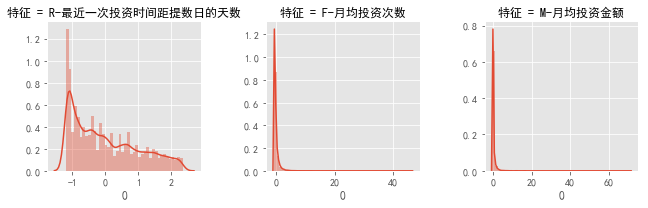

In [186]:
sns.FacetGrid(cdata.stack().reset_index().rename(columns={'level_1':'特征'}),col='特征',sharex=False,sharey=False).map(sns.distplot,0)

In [187]:
import numpy as np
def 离散点替换(cdata,x):
    cdata.loc[cdata[x]>=np.percentile(cdata[x],98),x]=np.percentile(cdata[x],98)
离散点替换(cdata,'F-月均投资次数')
离散点替换(cdata,'M-月均投资金额')

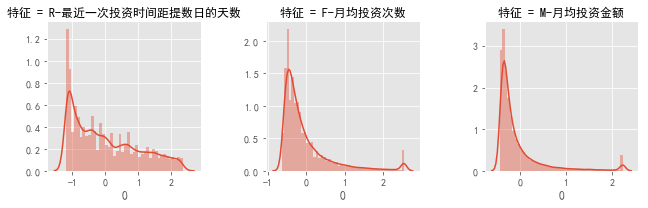

In [188]:
sns.FacetGrid(cdata.stack().reset_index().rename(columns={'level_1':'特征'}),col='特征',sharex=False,sharey=False).map(sns.distplot,0)

In [189]:
Kmodol=KMeans(n_clusters=4, n_jobs=4, max_iter=100, random_state=0)
Kmodol.fit(cdata)
cdata['类别']=Kmodol.labels_
cdata.head()

,R-最近一次投资时间距提数日的天数,F-月均投资次数,M-月均投资金额,类别
0,-0.356009,-0.032163,-0.175541,1
1,-0.356009,-0.032163,0.207898,1
2,-0.099838,-0.243671,0.259023,0
3,0.009949,-0.349425,-0.239448,0
4,-0.392605,-0.032163,0.846964,1


In [190]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

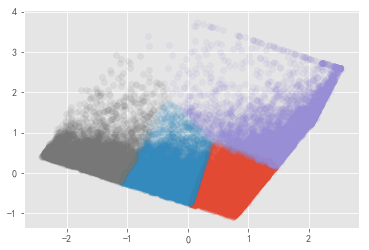

In [202]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x=['R-最近一次投资时间距提数日的天数','F-月均投资次数','M-月均投资金额']
pca.fit(np.array(cdata[x]))
cdata_pca=pd.DataFrame(pca.transform(np.array(cdata[x])))
cdata_pca['类别']=cdata.类别
for 类别 in cdata_pca.类别.unique():
    plt.scatter(cdata_pca.loc[cdata_pca.类别==类别,0],cdata_pca.loc[cdata_pca.类别==类别,1],alpha=0.1)

In [193]:
cluster_centers=pd.DataFrame(Kmodol.cluster_centers_).rename(columns={0:'R-最近一次投资时间距提数日的天数',1:'F-月均投资次数',2:'M-月均投资金额'})
data1=pd.concat([cluster_centers,pd.Series(Kmodol.labels_).value_counts()],axis=1).rename(columns={0:'数量'})
data1

,R-最近一次投资时间距提数日的天数,F-月均投资次数,M-月均投资金额,数量
0,0.289433,-0.314164,-0.183901,14591
1,-0.803644,-0.052304,-0.106468,19529
2,-0.872031,1.406151,0.863040,5370
3,1.586791,-0.388323,-0.223294,10195


[Text(0, 0, 'R-最近一次投资时间距提数日的天数'),
 Text(0, 0, 'F-月均投资次数'),
 Text(0, 0, 'M-月均投资金额')]

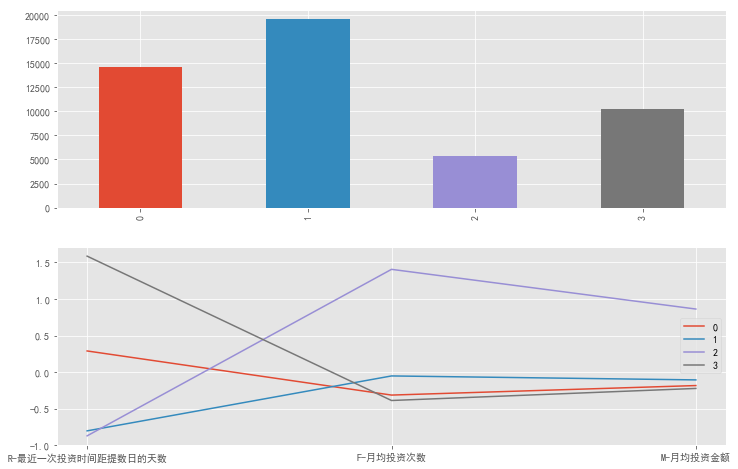

In [194]:
fig=plt.figure(figsize=(12,8))
fig.add_subplot(211)
data1.数量.plot(kind='bar')
fig.add_subplot(212)
for i in data1.drop('数量',axis=1).T.columns:
    plt.plot(np.arange(1,len(data1.drop('数量',axis=1))),data1.drop('数量',axis=1).T[i])
plt.legend()
ax=plt.gca() 
ax.set_xticks(np.arange(1,len(data1.drop('数量',axis=1))))
ax.set_xticklabels(data1.drop('数量',axis=1).columns)

In [196]:
# 统计每个类别的频率
value_counts = Series(Kmodol.labels_).value_counts()
print(value_counts)

1    19529
0    14591
3    10195
2     5370
dtype: int64


In [200]:
# 将类别标签赋回原来的数据
cdata_rst = pd.concat([cdata, Series(Kmodol.labels_, index=cdata.index)], axis=1).drop(0,axis=1)
cdata_rst.head()

,R-最近一次投资时间距提数日的天数,F-月均投资次数,M-月均投资金额,类别
0,-0.356009,-0.032163,-0.175541,1
1,-0.356009,-0.032163,0.207898,1
2,-0.099838,-0.243671,0.259023,0
3,0.009949,-0.349425,-0.239448,0
4,-0.392605,-0.032163,0.846964,1


In [201]:
# 按照类别分组统计R, F, M的指标均值
user_ret = cdata_rst.groupby(cdata_rst["类别"]).mean()
user_ret

,R-最近一次投资时间距提数日的天数,F-月均投资次数,M-月均投资金额
类别,,,
0,0.288508,-0.314055,-0.184197
1,-0.803969,-0.052327,-0.106699
2,-0.871445,1.404330,0.863352
3,1.586146,-0.388433,-0.223333
